In [13]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:


# 경로 설정
base_path = 'D:/LabRoom/Projects/SD Physiology/Processed/processed_individual_anonymized'
participant_list = sorted(list(set(f.split("_")[0] for f in os.listdir(base_path) if f.endswith("_Main.pkl"))))

# 파라미터 설정
fps = 120
window_seconds = 30
stride_seconds = 15

window_size = window_seconds * fps
stride_size = stride_seconds * fps


# Step 1️⃣: 데이터 불러오기 및 Outside 필터링
data_dict = {}

for name in tqdm(participant_list, desc="Loading and Filtering"):
    file_path = os.path.join(base_path, f"{name}_Main.pkl")
    try:
        df = pd.read_pickle(file_path)
        df_outside = df[df['scene'] == 'Outside'].copy()
        if len(df_outside) >= window_size:
            data_dict[name] = df_outside
    except Exception as e:
        print(f"{name}: 오류 발생 - {e}")
        


Loading and Filtering: 100%|██████████| 108/108 [00:25<00:00,  4.30it/s]


In [15]:

# Step 0️⃣: 예시 participant로부터 column 구조만 추출
sample_name = participant_list[0]
sample_df = pd.read_pickle(os.path.join(base_path, f"{sample_name}_Main.pkl"))
sample_df = sample_df[sample_df['scene'] == 'Outside'].copy()
sample_df.reset_index(drop=True, inplace=True)

exclude_keywords = [
    'unit',       # face tracker
    'Frame',      # 단순 index
    'X_pos', 'Y_pos', 'Z_pos',     # 위치 좌표
    'X_rot', 'Y_rot', 'Z_rot',     # 회전값
    'validL', 'validR',            # 눈 추적 유효 여부 (bool성태 숫자)
    'gazeorigin', 'gazeL_', 'gazeR_',  # 시선 방향 좌표
    'pupilLSensorPos',             # 동공 센서 위치
     'eye_openness'
]
feature_cols = [
    col for col in sample_df.columns
    if (
        col not in ['anxiety', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        sample_df[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

Generating Windows: 100%|██████████| 108/108 [00:10<00:00,  9.89it/s]


✅ 최종 window 수: 2300
🚫 NaN 때문에 제외된 window 수: 56


,participant,start_idx,note
0,064,0,All NaN in anxiety
1,064,1800,All NaN in anxiety
2,064,3600,All NaN in anxiety
3,064,5400,All NaN in anxiety
4,064,7200,All NaN in anxiety


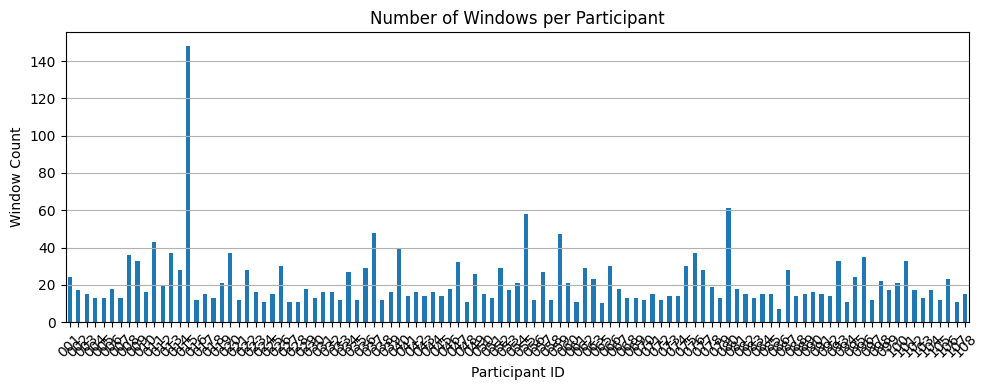

In [16]:
windowed_data = []
nan_log = []  # NaN 로그 저장
for name, df in tqdm(data_dict.items(), desc="Generating Windows"):
    df = df.reset_index(drop=True)
    for start in range(0, len(df) - window_size + 1, stride_size):
        end = start + window_size
        window_df = df.iloc[start:end]

        anxiety_values = window_df["anxiety"]
        anxiety_mean = anxiety_values.mean()

        # NaN인지 먼저 확인
        if np.isnan(anxiety_mean):
            nan_log.append({
                "participant": name,
                "start_idx": start,
                "note": "All NaN in anxiety"
            })
            continue  # 이 window는 skip

        features = {}
        for col in feature_cols:
            features[f"{col}_mean"] = window_df[col].mean()
            features[f"{col}_std"] = window_df[col].std()

        features["anxiety_mean"] = anxiety_mean
        features["participant"] = name
        features["start_idx"] = start
        windowed_data.append(features)

# 결과 저장
window_df_all = pd.DataFrame(windowed_data)
nan_log_df = pd.DataFrame(nan_log)

print(f"\n✅ 최종 window 수: {len(window_df_all)}")
print(f"🚫 NaN 때문에 제외된 window 수: {len(nan_log_df)}")

# 필요 시 확인
display(nan_log_df.head())


# Step 4️⃣: 참가자별 window 수 시각화
participant_counts = window_df_all['participant'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
participant_counts.plot(kind='bar')
plt.title("Number of Windows per Participant")
plt.xlabel("Participant ID")
plt.ylabel("Window Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [17]:
window_df_all = window_df_all[window_df_all["participant"] != "nsk9105"].reset_index(drop=True)

print(f"🚫 NaN 포함 참가자 'nsk9105' 제거 후 window 수: {len(window_df_all)}")

# 참가자별 window 개수 집계
participant_counts = window_df_all['participant'].value_counts()

# 5개 미만인 참가자만 추출
too_short = participant_counts[participant_counts < 5]

# 결과 출력
print(f"🚫 너무 짧은 참가자 수 (<5 windows): {len(too_short)}명")
display(too_short)

🚫 NaN 포함 참가자 'nsk9105' 제거 후 window 수: 2300
🚫 너무 짧은 참가자 수 (<5 windows): 0명


Series([], Name: count, dtype: int64)

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # ✔️ tqdm.notebook 사용
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

# ✅ Feature/Target 추출
def get_feature_target(df):
    feature_cols = [col for col in df.columns if any(
        kw in col for kw in ["PPG", "RSP", "EDA", "pupil"])]
    X = df[feature_cols]
    y = df["anxiety_mean"]
    groups = df["participant"]
    return X, y, groups

# ✅ Step 1: 전체 참가자 기반 GridSearchCV로 Best Param 찾기
def get_best_params_global(df):
    X, y, _ = get_feature_target(df)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', CatBoostRegressor(silent=True))
    ])

    param_grid = {
        'model__depth': [4, 6, 8],
        'model__learning_rate': [0.03, 0.1],
        'model__l2_leaf_reg': [1, 3]
    }

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    return grid.best_params_

# ✅ Step 2: LOPO Evaluation with Fixed Best Param
def run_lopo_with_fixed_params(df, best_params):
    X, y, groups = get_feature_target(df)
    logo = LeaveOneGroupOut()
    results = []

    # ✔️ tqdm 적용
    loop = tqdm(logo.split(X, y, groups), total=len(np.unique(groups)), desc="LOPO 진행중")

    for train_idx, test_idx in loop:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', CatBoostRegressor(
                silent=True,
                depth=best_params['model__depth'],
                learning_rate=best_params['model__learning_rate'],
                l2_leaf_reg=best_params['model__l2_leaf_reg'],
            ))
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        results.append({
            "participant": groups.iloc[test_idx].iloc[0],
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae,
        })

    return pd.DataFrame(results)
# ✅ 실행
best_params = get_best_params_global(window_df_all)
print("🔍 Best Params:", best_params)

results_df = run_lopo_with_fixed_params(window_df_all, best_params)

# ✅ 저장 + 요약 출력
results_df.to_csv("catboost_lopo_results.csv", index=False)
print("\n📊 결과 요약:")
print(results_df.describe())


In [ ]:
results_df.sort_values(by='R2', ascending=False).iloc[:10]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# ✅ Boxplot & Histogram for R²
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(results_df["R2"].dropna())
plt.title("R² Boxplot")
plt.ylabel("R²")

plt.subplot(1, 2, 2)
plt.hist(results_df["R2"].dropna(), bins=20, edgecolor='black')
plt.title("R² Histogram")
plt.xlabel("R²")
plt.tight_layout()
plt.show()

# ✅ Boxplot & Histogram for RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(results_df["RMSE"].dropna())
plt.title("RMSE Boxplot")
plt.ylabel("RMSE")

plt.subplot(1, 2, 2)
plt.hist(results_df["RMSE"].dropna(), bins=20, edgecolor='black')
plt.title("RMSE Histogram")
plt.xlabel("RMSE")
plt.tight_layout()
plt.show()

# ✅ Boxplot & Histogram for MAE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(results_df["MAE"].dropna())
plt.title("MAE Boxplot")
plt.ylabel("MAE")

plt.subplot(1, 2, 2)
plt.hist(results_df["MAE"].dropna(), bins=20, edgecolor='black')
plt.title("MAE Histogram")
plt.xlabel("MAE")
plt.tight_layout()
plt.show()


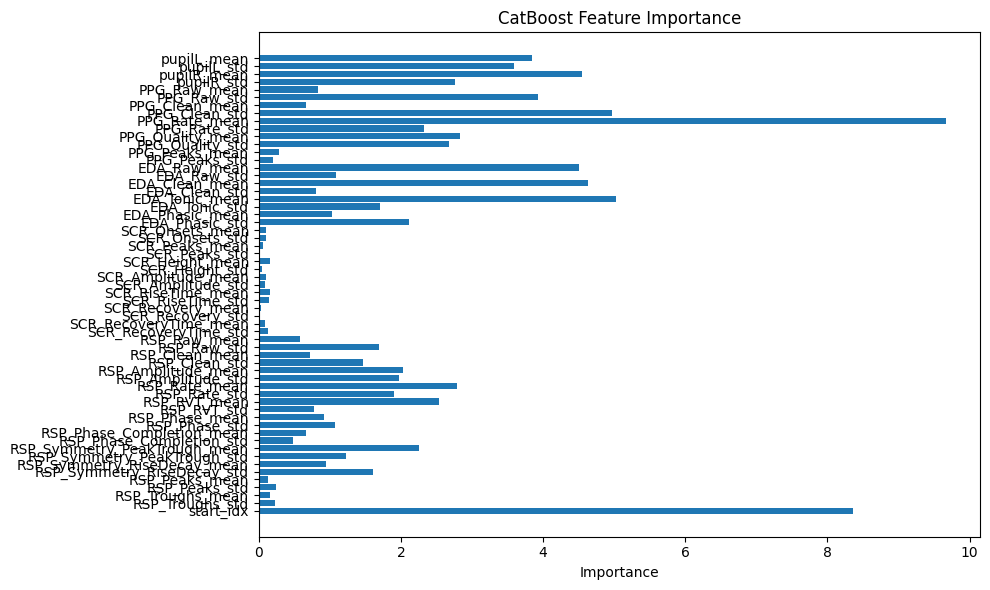

In [20]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

# 📌 전체 데이터 (feature + target) 준비
X_all = window_df_all.drop(columns=["participant", "anxiety_mean"])
y_all = window_df_all["anxiety_mean"]

# 🧠 CatBoost 학습 (fast)
model = CatBoostRegressor(verbose=0)
model.fit(X_all, y_all)

# 📊 Feature Importance 시각화
importances = model.get_feature_importance()
feature_names = X_all.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tqdm import tqdm  # ✅ 진행 시각화

# ✅ 데이터 준비
drop_cols = ['anxiety_mean', 'participant', 'start_idx']
X = window_df_all.drop(columns=drop_cols)
y = window_df_all['anxiety_mean'].values
participants = window_df_all['participant'].values

unique_pids = np.unique(participants)
train_pids, testval_pids = train_test_split(unique_pids, test_size=0.3, random_state=42)
val_pids, test_pids = train_test_split(testval_pids, test_size=0.5, random_state=42)

train_mask = np.isin(participants, train_pids)
val_mask = np.isin(participants, val_pids)
test_mask = np.isin(participants, test_pids)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

# ✅ 모델 정의
models = {
    'LinearSVR': LinearSVR(max_iter=1000, random_state=42),
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(n_estimators=100, random_state=42, verbose=0),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42, early_stopping=True)
}

# ✅ 결과 저장
results = []
feature_info = []

print("🚀 모델 학습 및 평가 시작")
for name, model in tqdm(models.items(), desc="모델 진행 중"):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    results.append({
        'Model': name,
        'R2_Train': r2_score(y_train, y_train_pred),
        'R2_Val': r2_score(y_val, y_val_pred),
        'R2_Test': r2_score(y_test, y_test_pred),
        'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE_Val': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE_Train': mean_absolute_error(y_train, y_train_pred),
        'MAE_Val': mean_absolute_error(y_val, y_val_pred),
        'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    })

    feature_info.append({
        'Model': name,
        'Features Used': list(X.columns)
    })

    print(f"✅ {name} 완료")

results_df = pd.DataFrame(results).sort_values(by='R2_Test', ascending=False)
feature_df = pd.DataFrame(feature_info)

# ✅ 시각화 (모델 완료 후 일괄)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
metrics = ['R2', 'RMSE', 'MAE']
sets = ['Train', 'Val', 'Test']

os.makedirs("figures", exist_ok=True)

for metric in metrics:
    plt.figure(figsize=(10, 6))
    bar_width = 0.25
    index = np.arange(len(results_df))
    for i, subset in enumerate(sets):
        plt.bar(index + i * bar_width,
                results_df[f'{metric}_{subset}'],
                width=bar_width,
                label=subset)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(index + bar_width, results_df['Model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/{metric}_comparison_{timestamp}.png')
    plt.show()

# ✅ 결과 출력
print("📋 전체 결과 요약:")
print(results_df)

print("\n🧩 사용된 Feature 목록:")
print(feature_df)


In [ ]:
import pandas as pd

# 제외할 컬럼 정의
drop_cols = ['anxiety_mean', 'participant', 'start_idx']
feature_cols = [col for col in window_df_all.columns if col not in drop_cols]

# Z-score normalization 함수 정의
def zscore_normalize_by_participant(df, feature_cols, participant_col='participant'):
    df_normalized = df.copy()
    for pid in df[participant_col].unique():
        mask = df[participant_col] == pid
        subset = df.loc[mask, feature_cols]
        means = subset.mean()
        stds = subset.std()
        df_normalized.loc[mask, feature_cols] = (subset - means) / stds
    return df_normalized

# 정규화 적용
normalized_df = zscore_normalize_by_participant(window_df_all, feature_cols)

# NaN 비율 확인
nan_counts = normalized_df[feature_cols].isna().sum()
nan_ratio = nan_counts / len(normalized_df)

# 출력
print("📉 NaN 비율 상위 10개:")
print(nan_ratio.sort_values(ascending=False).head(10))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectKBest, f_regression

from tqdm import tqdm

# ✅ 데이터 준비 및 정규화
drop_cols = ['anxiety_mean', 'participant', 'start_idx']
X = window_df_all.drop(columns=drop_cols)
y = window_df_all['anxiety_mean'].values
participants = window_df_all['participant'].values

# NaN 처리
# X = X.dropna(axis=1, thresh=int(0.7 * len(X)))  # NaN 30% 이상인 열 제거
# X = X.fillna(X.mean())  # 나머지 평균 대체

# Participant 기준 split
# participant별 window 수 집계
participant_counts = pd.Series(participants).value_counts()
participant_counts = participant_counts.sample(frac=1, random_state=42)  # 셔플

# 목표 비율
total_windows = participant_counts.sum()
train_target = int(total_windows * 0.8)
val_target = int(total_windows * 0.1)

# participant 분배
train_pids, val_pids, test_pids = [], [], []
counts_cumsum = 0

for pid, count in participant_counts.items():
    if counts_cumsum < train_target:
        train_pids.append(pid)
    elif counts_cumsum < train_target + val_target:
        val_pids.append(pid)
    else:
        test_pids.append(pid)
    counts_cumsum += count

# 마스크 생성
train_mask = np.isin(participants, train_pids)
val_mask = np.isin(participants, val_pids)
test_mask = np.isin(participants, test_pids)

# split
X_train_raw, y_train = X[train_mask], y[train_mask]
X_val_raw, y_val = X[val_mask], y[val_mask]
X_test_raw, y_test = X[test_mask], y[test_mask]


# ✅ 정규화 (스케일링은 RFECV 전에 미리)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_raw), columns=X_val_raw.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns)

# ✅ 모델 정의 + RFECV 설정
models = {
    'LinearSVR': LinearSVR(max_iter=1000, random_state=42),
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=300, random_state=42),
    'CatBoost': CatBoostRegressor(n_estimators=300, random_state=42, verbose=0),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42, early_stopping=True)
}

rfecv_config = {
    'LinearSVR': {'use_rfecv': True, 'importance_getter': 'coef_'},
    'Ridge': {'use_rfecv': True, 'importance_getter': 'coef_'},
    'RandomForest': {'use_rfecv': True, 'importance_getter': 'feature_importances_'},
    'XGBoost': {'use_rfecv': True, 'importance_getter': 'feature_importances_'},
    'LightGBM': {'use_rfecv': True, 'importance_getter': 'feature_importances_'},
    'CatBoost': {'use_rfecv': True, 'importance_getter': 'feature_importances_'},
    'MLP': {'use_rfecv': False},  # 여전히 RFECV 불가
}

# 결과 저장 구조 동일
results = []
feature_info = []
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

print("🚀 모델 학습 및 평가 시작")

for name, model in tqdm(models.items(), desc="모델 진행 중"):
    print(f"\n⚙️  Feature selection for {name}...")

    config = rfecv_config[name]
    if config['use_rfecv']:
        try:
            rfecv = RFECV(
                estimator=model,
                step=1,
                cv=KFold(n_splits=3, shuffle=True, random_state=42),
                scoring='r2',
                n_jobs=-1,
                importance_getter=config['importance_getter']
            )
            rfecv.fit(X_train_scaled, y_train)
            X_train_sel = rfecv.transform(X_train_scaled)
            X_val_sel = rfecv.transform(X_val_scaled)
            X_test_sel = rfecv.transform(X_test_scaled)
            selected_features = X_train_scaled.columns[rfecv.support_]
            print(f"✅ {name} 완료 - 선택된 feature 수: {len(selected_features)}")
        except Exception as e:
            print(f"⚠️  {name} - RFECV 실패: {e}")
            X_train_sel = X_train_scaled
            X_val_sel = X_val_scaled
            X_test_sel = X_test_scaled
            selected_features = X_train_scaled.columns
    else:
        print(f"⚠️  {name} - RFECV 불가능, SelectKBest 사용")
        selector = SelectKBest(f_regression, k='all')
        selector.fit(X_train_scaled, y_train)
        X_train_sel = selector.transform(X_train_scaled)
        X_val_sel = selector.transform(X_val_scaled)
        X_test_sel = selector.transform(X_test_scaled)
        selected_features = X_train_scaled.columns[selector.get_support()]

    model.fit(X_train_sel, y_train)
    y_train_pred = model.predict(X_train_sel)
    y_val_pred = model.predict(X_val_sel)
    y_test_pred = model.predict(X_test_sel)

    results.append({
        'Model': name,
        'R2_Train': r2_score(y_train, y_train_pred),
        'R2_Val': r2_score(y_val, y_val_pred),
        'R2_Test': r2_score(y_test, y_test_pred),
        'RMSE_Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE_Val': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE_Train': mean_absolute_error(y_train, y_train_pred),
        'MAE_Val': mean_absolute_error(y_val, y_val_pred),
        'MAE_Test': mean_absolute_error(y_test, y_test_pred),
    })

    feature_info.append({
        'Model': name,
        'Num Features': len(selected_features),
        'Features Used': list(selected_features)
    })
# ✅ 결과 정리 및 시각화
results_df = pd.DataFrame(results).sort_values(by='R2_Test', ascending=False)
feature_df = pd.DataFrame(feature_info)

metrics = ['R2', 'RMSE', 'MAE']
sets = ['Train', 'Val', 'Test']

os.makedirs("figures", exist_ok=True)
for metric in metrics:
    plt.figure(figsize=(10, 6))
    bar_width = 0.25
    index = np.arange(len(results_df))
    for i, subset in enumerate(sets):
        plt.bar(index + i * bar_width,
                results_df[f'{metric}_{subset}'],
                width=bar_width,
                label=subset)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(index + bar_width, results_df['Model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/{metric}_comparison_{timestamp}.png')
    plt.show()

# ✅ 출력
print("\n📋 전체 결과 요약:")
print(results_df)

print("\n🧩 사용된 Feature 목록:")
print(feature_df)


In [ ]:
window_df_all

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from itertools import product
import numpy as np
import pandas as pd

ppg_exclude_df = pd.read_csv("./abnormal_ppg_anonymized.csv")
rsp_exclude_df = pd.read_csv("./abnormal_rsp_anonymized.csv")
eda_exclude_df = pd.read_csv("./abnormal_eda_anonymized.csv")

exclude_ppg_ids = set(ppg_exclude_df.loc[ppg_exclude_df["exclude_flag_ppg"], "Anonymized_ID"].dropna().astype(int))
exclude_rsp_ids = set(rsp_exclude_df.loc[rsp_exclude_df["exclude_flag_rsp"], "Anonymized_ID"].dropna().astype(int))
exclude_eda_ids = set(eda_exclude_df.loc[eda_exclude_df["exclude_flag_eda"], "Anonymized_ID"].dropna().astype(int))
window_df_all['participant'] = window_df_all['participant'].astype(int)
# Step 1: Apply exclusion before split
df_cleaned = window_df_all.copy()
for pid in df_cleaned['participant'].unique():
    pid_mask = df_cleaned['participant'] == pid
    if pid in exclude_ppg_ids:
        df_cleaned.loc[pid_mask, df_cleaned.columns[df_cleaned.columns.str.contains("PPG")]] = np.nan
    if pid in exclude_rsp_ids:
        df_cleaned.loc[pid_mask, df_cleaned.columns[df_cleaned.columns.str.contains("RSP")]] = np.nan
    if pid in exclude_eda_ids:
        df_cleaned.loc[pid_mask, df_cleaned.columns[df_cleaned.columns.str.contains("EDA")]] = np.nan

# Step 2: Drop NaNs row-wise
df_cleaned = df_cleaned.dropna()

# Step 3: 튜닝용 split
all_pids = np.unique(df_cleaned['participant'].values)
np.random.seed(42)
val_pids = np.random.choice(all_pids, size=int(0.2 * len(all_pids)), replace=False)
train_pids = np.setdiff1d(all_pids, val_pids)

X_train = df_cleaned[df_cleaned['participant'].isin(train_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_train = df_cleaned[df_cleaned['participant'].isin(train_pids)]['anxiety_mean'].values
X_val = df_cleaned[df_cleaned['participant'].isin(val_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_val = df_cleaned[df_cleaned['participant'].isin(val_pids)]['anxiety_mean'].values
# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 튜닝 후보
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [3, 5, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [ 2, 4]
}

# 튜닝 수행
best_score = -np.inf
best_params = None
for combo in product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    model = RandomForestRegressor(**params, random_state=42)
    try:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        score = r2_score(y_val, y_val_pred)
        if score > best_score:
            best_score = score
            best_params = params
    except Exception as e:
        continue

print("✅ Best hyperparameters from validation:")
print(best_params)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

def prepare_lopo_data(df, test_pid, target_col="anxiety_mean", drop_cols=["participant"], normalize=True, remove_baseline=True, remove_global_mean=False):
    df_train = df[df["participant"] != test_pid].copy()
    df_test = df[df["participant"] == test_pid].copy()

    if df_test.shape[0] == 0 or df_train.shape[0] == 0:
        return None, None, None, None

    y_train = df_train[target_col].values
    y_test = df_test[target_col].values

    X_train = df_train.drop(columns=drop_cols + [target_col])
    X_test = df_test.drop(columns=drop_cols + [target_col])

    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if remove_baseline:
        baseline_mean = np.mean(y_train)
        y_train = y_train - baseline_mean
        y_test = y_test - baseline_mean

        if remove_global_mean:
            y_train = y_train - np.mean(y_train)
            y_test = y_test - np.mean(y_train)

    return X_train, y_train, X_test, y_test

def run_lopo_evaluation(df, all_pids, best_params, normalize=True, remove_baseline=True, remove_global_mean=False, target_col="anxiety_mean"):
    results = []

    for i, test_pid in enumerate(all_pids):
        print(f"[{i+1}/{len(all_pids)}] PID {test_pid} processing...")

        result = prepare_lopo_data(
            df, test_pid,
            target_col=target_col,
            normalize=normalize,
            remove_baseline=remove_baseline,
            remove_global_mean=remove_global_mean
        )

        if result[0] is None:
            print(f"❌ Skipped PID {test_pid}: insufficient data")
            continue

        X_train, y_train, X_test, y_test = result

        if X_test.shape[0] == 0:
            print(f"❌ Skipped PID {test_pid}: empty test set after filtering")
            continue

        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # 수동 RMSE 계산
        mae = mean_absolute_error(y_test, y_pred)

        results.append({
            "participant": test_pid,
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae,
        })

    return pd.DataFrame(results)
rf_lopo_df = run_lopo_evaluation(
    df=window_df_all,
    all_pids=window_df_all['participant'].unique(),
    best_params=best_params,
    normalize=True,
    remove_baseline=True,
    remove_global_mean=True,
    target_col="anxiety_mean"
)

print(rf_lopo_df.describe())


In [ ]:
rf_lopo_df['R2'].mean()

In [ ]:
window_df_all.columns

### Ridge

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm

# 하이퍼파라미터 후보 (알파값은 정규화 세기)
alphas = np.logspace(-3, 3, 10)  # 0.001 ~ 1000

# 결과 저장
ridge_lopo_results = []

# 참가자 목록
all_pids = np.unique(window_df_all['participant'].values)

# LOPO 실행
for test_pid in tqdm(all_pids, desc="Ridge LOPO"):
    # Train/Test 분리
    train_mask = window_df_all['participant'] != test_pid
    test_mask = window_df_all['participant'] == test_pid

    X_train = window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_train = window_df_all[train_mask]['anxiety_mean'].values
    X_test = window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_test = window_df_all[test_mask]['anxiety_mean'].values

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # RidgeCV 학습
    ridge = RidgeCV(alphas=alphas, scoring='r2')
    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_test_scaled)

    # 성능 저장
    ridge_lopo_results.append({
        'TestPID': test_pid,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'BestAlpha': ridge.alpha_
    })

# 결과 정리
ridge_lopo_df = pd.DataFrame(ridge_lopo_results)
summary = {
    'N': len(ridge_lopo_df),
    'Mean R2': ridge_lopo_df['R2'].mean(),
    'Mean RMSE': ridge_lopo_df['RMSE'].mean(),
    'Mean MAE': ridge_lopo_df['MAE'].mean()
}

print("\n📊 Ridge LOPO 결과 요약:")
print(pd.DataFrame([summary]))


### SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tqdm import tqdm

# 📌 참가자 분할
all_pids = np.unique(window_df_all['participant'].values)
np.random.seed(42)
val_pids = np.random.choice(all_pids, size=int(0.2 * len(all_pids)), replace=False)
train_pids = np.setdiff1d(all_pids, val_pids)

# 데이터 분리
X_train = window_df_all[window_df_all['participant'].isin(train_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_train = window_df_all[window_df_all['participant'].isin(train_pids)]['anxiety_mean'].values
X_val = window_df_all[window_df_all['participant'].isin(val_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_val = window_df_all[window_df_all['participant'].isin(val_pids)]['anxiety_mean'].values

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ✅ 하이퍼파라미터 그리드
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2],
    'kernel': ['linear', 'rbf']
}

best_score = -np.inf
best_params = None

# 🔍 Validation을 통한 튜닝
for params in ParameterGrid(param_grid):
    model = SVR(**params)
    try:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        score = r2_score(y_val, y_val_pred)
        if score > best_score:
            best_score = score
            best_params = params
    except:
        continue

print("✅ Best SVR params:", best_params)

# 🧪 LOPO with best SVR model
svr_lopo_results = []

for test_pid in tqdm(all_pids, desc="LOPO-SVR"):
    train_mask = window_df_all['participant'] != test_pid
    test_mask = window_df_all['participant'] == test_pid

    X_train = window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_train = window_df_all[train_mask]['anxiety_mean'].values
    X_test = window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_test = window_df_all[test_mask]['anxiety_mean'].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(**best_params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    svr_lopo_results.append({
        'TestPID': test_pid,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

svr_lopo_df = pd.DataFrame(svr_lopo_results)
summary = {
    'N': len(svr_lopo_df),
    'Mean R2': svr_lopo_df['R2'].mean(),
    'Mean RMSE': svr_lopo_df['RMSE'].mean(),
    'Mean MAE': svr_lopo_df['MAE'].mean()
}

print("\n📊 LOPO-SVR 결과 요약:")
print(pd.DataFrame([summary]))


### Catboost

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tqdm import tqdm

# 참가자 분할
all_pids = np.unique(window_df_all['participant'].values)
np.random.seed(42)
val_pids = np.random.choice(all_pids, size=int(0.2 * len(all_pids)), replace=False)
train_pids = np.setdiff1d(all_pids, val_pids)

# 데이터 분리
X_train = window_df_all[window_df_all['participant'].isin(train_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_train = window_df_all[window_df_all['participant'].isin(train_pids)]['anxiety_mean'].values
X_val = window_df_all[window_df_all['participant'].isin(val_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_val = window_df_all[window_df_all['participant'].isin(val_pids)]['anxiety_mean'].values

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 파라미터 그리드
param_grid = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5]
}

best_score = -np.inf
best_params = None

# validation 기반 튜닝
for params in ParameterGrid(param_grid):
    model = CatBoostRegressor(verbose=0, random_state=42, **params)
    try:
        model.fit(X_train_scaled, y_train)
        y_val_pred = model.predict(X_val_scaled)
        score = r2_score(y_val, y_val_pred)
        if score > best_score:
            best_score = score
            best_params = params
    except Exception as e:
        continue

print("✅ Best CatBoost params:", best_params)

# LOPO 평가
catboost_lopo_results = []

for test_pid in tqdm(all_pids, desc="LOPO-CatBoost"):
    train_mask = window_df_all['participant'] != test_pid
    test_mask = window_df_all['participant'] == test_pid

    X_train = window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_train = window_df_all[train_mask]['anxiety_mean'].values
    X_test = window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
    y_test = window_df_all[test_mask]['anxiety_mean'].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = CatBoostRegressor(verbose=0, random_state=42, **best_params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    catboost_lopo_results.append({
        'TestPID': test_pid,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

catboost_lopo_df = pd.DataFrame(catboost_lopo_results)
summary = {
    'N': len(catboost_lopo_df),
    'Mean R2': catboost_lopo_df['R2'].mean(),
    'Mean RMSE': catboost_lopo_df['RMSE'].mean(),
    'Mean MAE': catboost_lopo_df['MAE'].mean()
}

print("\n📊 LOPO-CatBoost 결과 요약:")
print(pd.DataFrame([summary]))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 참가자 split
all_pids = np.unique(window_df_all['participant'])
np.random.seed(42)
val_pids = np.random.choice(all_pids, size=int(0.2 * len(all_pids)), replace=False)
train_pids = np.setdiff1d(all_pids, val_pids)

# train/val 분리
X_train = window_df_all[window_df_all['participant'].isin(train_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_train = window_df_all[window_df_all['participant'].isin(train_pids)]['anxiety_mean'].values
X_val = window_df_all[window_df_all['participant'].isin(val_pids)].drop(columns=['anxiety_mean', 'participant', 'start_idx'])
y_val = window_df_all[window_df_all['participant'].isin(val_pids)]['anxiety_mean'].values

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

best_score = -np.inf
best_params = None
for params in ParameterGrid(param_grid):
    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    score = r2_score(y_val, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

print("✅ Best params (GBRT):", best_params)

# LOPO
gbrt_results = []
for pid in tqdm(all_pids, desc="LOPO - GBRT"):
    train_mask = window_df_all['participant'] != pid
    test_mask = window_df_all['participant'] == pid

    X_tr = scaler.transform(window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_tr = window_df_all[train_mask]['anxiety_mean'].values
    X_te = scaler.transform(window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_te = window_df_all[test_mask]['anxiety_mean'].values

    model = GradientBoostingRegressor(**best_params, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    gbrt_results.append({
        'TestPID': pid,
        'R2': r2_score(y_te, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
        'MAE': mean_absolute_error(y_te, y_pred)
    })

gbrt_df = pd.DataFrame(gbrt_results)
print("\n📊 LOPO-GBRT 결과 요약:")
print(pd.DataFrame([{
    'N': len(gbrt_df),
    'Mean R2': gbrt_df['R2'].mean(),
    'Mean RMSE': gbrt_df['RMSE'].mean(),
    'Mean MAE': gbrt_df['MAE'].mean()
}]))


### MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor

# 하이퍼파라미터 튜닝
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

best_score = -np.inf
best_params = None
for params in ParameterGrid(param_grid):
    model = MLPRegressor(max_iter=500, random_state=42, **params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    score = r2_score(y_val, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

print("✅ Best params (MLP):", best_params)

# LOPO
mlp_results = []
for pid in tqdm(all_pids, desc="LOPO - MLP"):
    train_mask = window_df_all['participant'] != pid
    test_mask = window_df_all['participant'] == pid

    X_tr = scaler.transform(window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_tr = window_df_all[train_mask]['anxiety_mean'].values
    X_te = scaler.transform(window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_te = window_df_all[test_mask]['anxiety_mean'].values

    model = MLPRegressor(max_iter=500, random_state=42, **best_params)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    mlp_results.append({
        'TestPID': pid,
        'R2': r2_score(y_te, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
        'MAE': mean_absolute_error(y_te, y_pred)
    })

mlp_df = pd.DataFrame(mlp_results)
print("\n📊 LOPO-MLP 결과 요약:")
print(pd.DataFrame([{
    'N': len(mlp_df),
    'Mean R2': mlp_df['R2'].mean(),
    'Mean RMSE': mlp_df['RMSE'].mean(),
    'Mean MAE': mlp_df['MAE'].mean()
}]))


### LGBMRegrassor

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

best_score = -np.inf
best_params = None
for params in ParameterGrid(param_grid):
    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    score = r2_score(y_val, y_pred)
    if score > best_score:
        best_score = score
        best_params = params

print("✅ Best params (LGBM):", best_params)

# LOPO
lgbm_results = []
for pid in tqdm(all_pids, desc="LOPO - LGBM"):
    train_mask = window_df_all['participant'] != pid
    test_mask = window_df_all['participant'] == pid

    X_tr = scaler.transform(window_df_all[train_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_tr = window_df_all[train_mask]['anxiety_mean'].values
    X_te = scaler.transform(window_df_all[test_mask].drop(columns=['anxiety_mean', 'participant', 'start_idx']))
    y_te = window_df_all[test_mask]['anxiety_mean'].values

    model = LGBMRegressor(**best_params, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    lgbm_results.append({
        'TestPID': pid,
        'R2': r2_score(y_te, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
        'MAE': mean_absolute_error(y_te, y_pred)
    })

lgbm_df = pd.DataFrame(lgbm_results)
print("\n📊 LOPO-LGBM 결과 요약:")
print(pd.DataFrame([{
    'N': len(lgbm_df),
    'Mean R2': lgbm_df['R2'].mean(),
    'Mean RMSE': lgbm_df['RMSE'].mean(),
    'Mean MAE': lgbm_df['MAE'].mean()
}]))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# R² by TestPID
plt.figure(figsize=(12, 5))
sns.barplot(x='TestPID', y='R2', data=rf_lopo_df)
plt.title('LOPO R² by Participant')
plt.xticks(rotation=90)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# MAE by TestPID
plt.figure(figsize=(12, 5))
sns.barplot(x='TestPID', y='MAE', data=rf_lopo_df)
plt.title('LOPO MAE by Participant')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

metrics = ['R2', 'RMSE', 'MAE']
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(rf_lopo_df[metric], kde=True, bins=20)
    plt.title(f'Distribution of {metric} across participants')
    plt.xlabel(metric)
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize=(6, 5))
sns.scatterplot(x='R2', y='MAE', data=rf_lopo_df)
plt.title('R² vs. MAE per participant')
plt.xlabel('R²')
plt.ylabel('MAE')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


### Difference

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def extract_diff_features(window_df_all, raw_df_dict, feature_cols, window_size_sec=30, sampling_rate=120):
    """
    각 window에 대해 변화량 기반 feature(diff/slope)를 계산하여 새 DataFrame 반환
    - window_df_all: 각 row가 window 하나인 DataFrame
    - raw_df_dict: participant별 raw 시계열 DataFrame dict
    - feature_cols: 변화량 계산할 컬럼 리스트
    - window_size_sec: 윈도우 크기 (초)
    - sampling_rate: physiology 샘플링 속도 (Hz)
    """
    new_records = []

    for idx, row in window_df_all.iterrows():
        pid = row['participant']
        start_idx = int(row['start_idx'])
        end_idx = start_idx + window_size_sec * sampling_rate

        raw_df = raw_df_dict[pid]
        window_raw = raw_df.iloc[start_idx:end_idx]

        record = {
            'participant': pid,
            'start_idx': start_idx,
            'anxiety_mean': row['anxiety_mean'],
            'scene': row.get('scene', None)
        }

        for col in feature_cols:
            if col in window_raw.columns:
                series = window_raw[col].values

                # 1. 단순 차이
                record[f'diff_{col}'] = series[-1] - series[0]

                # 2. 선형 회귀 slope (optional)
                x = np.arange(len(series)).reshape(-1, 1)
                y = series.reshape(-1, 1)
                if np.any(np.isnan(y)) or np.any(np.isinf(y)):
                    slope = np.nan
                else:
                    model = LinearRegression()
                    model.fit(x, y)
                    slope = model.coef_[0][0]
                record[f'slope_{col}'] = slope

        new_records.append(record)

    # 새롭게 만든 변화량 기반 DataFrame
    diff_df = pd.DataFrame(new_records)
    return diff_df


In [ ]:
# 사용할 feature 컬럼 정의
feature_cols = [col for col in data_dict['bjs0602'].columns if col.startswith(('EDA_', 'PPG_', 'RSP_'))]

# diff/slope 기반 새 데이터 생성
window_df_diff = extract_diff_features(
    window_df_all=window_df_all,
    raw_df_dict=data_dict,
    feature_cols=feature_cols,
    window_size_sec=30,
    sampling_rate=120
)


In [ ]:
window_df_diff

In [ ]:
# 불필요한 column 제거 기준 정의
exclude_keywords = ['unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos', 'X_rot', 'Y_rot', 'Z_rot',
                    'validL', 'validR', 'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
                    'eye_openness']

# 사용 가능한 feature column 추출
valid_feature_cols = [
    col for col in window_df_diff.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_diff[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# 전체 데이터 사용
X = window_df_diff[valid_feature_cols]
y = window_df_diff['anxiety_mean'].values

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_grid, n_iter=30, cv=3, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(X_scaled, y)

best_params = random_search.best_params_
print("✅ Best RF Params:")
print(best_params)


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm

rf_lopo_results = []

for test_pid in tqdm(window_df_diff['participant'].unique(), desc="LOPO with diff features"):
    train_mask = window_df_diff['participant'] != test_pid
    test_mask = window_df_diff['participant'] == test_pid

    X_train = window_df_diff.loc[train_mask, valid_feature_cols]
    y_train = window_df_diff.loc[train_mask, 'anxiety_mean'].values
    X_test = window_df_diff.loc[test_mask, valid_feature_cols]
    y_test = window_df_diff.loc[test_mask, 'anxiety_mean'].values

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rf_lopo_results.append({
        'TestPID': test_pid,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

rf_lopo_df = pd.DataFrame(rf_lopo_results)

summary = {
    'N': len(rf_lopo_df),
    'Mean R2': rf_lopo_df['R2'].mean(),
    'Mean RMSE': rf_lopo_df['RMSE'].mean(),
    'Mean MAE': rf_lopo_df['MAE'].mean()
}

print("\n📊 LOPO 결과 요약:")
print(pd.DataFrame([summary]))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# R² by TestPID
plt.figure(figsize=(12, 5))
sns.barplot(x='TestPID', y='R2', data=rf_lopo_df)
plt.title('LOPO R² by Participant (Diff Feature)')
plt.xticks(rotation=90)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# MAE by TestPID
plt.figure(figsize=(12, 5))
sns.barplot(x='TestPID', y='MAE', data=rf_lopo_df)
plt.title('LOPO MAE by Participant (Diff Feature)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Metric distributions
metrics = ['R2', 'RMSE', 'MAE']
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.histplot(rf_lopo_df[metric], kde=True, bins=20)
    plt.title(f'Distribution of {metric} across participants')
    plt.xlabel(metric)
    plt.tight_layout()
    plt.show()

# R² vs. MAE
plt.figure(figsize=(6, 5))
sns.scatterplot(x='R2', y='MAE', data=rf_lopo_df)
plt.title('R² vs. MAE per participant (Diff Feature)')
plt.xlabel('R²')
plt.ylabel('MAE')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


### SVM